In [13]:
import requests
import sys
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
import networkscience as ns
from matplotlib import pyplot as plt
import seaborn as sns

In [14]:
datasets = ['Erasmus14.csv', 'Erasmus15.csv', 'Erasmus16.csv', 'Erasmus17.csv', 'Erasmus18.csv', 'Erasmus19.csv']
#local_dir = r"C:\Users\nicol\OneDrive\Desktop\scuola\NETWORK SCIENCE\progetto\data\\"
local_dir = "data/"

mobility_df = pd.read_csv(local_dir + datasets[0], sep=';',low_memory=False, header=0)
for i in range(1, len(datasets)):
    mobility_df = pd.concat([mobility_df, pd.read_csv(local_dir + datasets[i], sep=';',low_memory=False, header=0)], axis=0)

In [15]:
def filter_data(df):
    df= df[df['Participant Profile']=='Learner']
    df= df[df['Activity (mob)'].str.contains('Student')]
    df = df[~df['Activity (mob)'].str.contains('traineeship')]
    df = df.loc[:, ['Sending Country Code', 'Sending Organization','Receiving Country Code', 'Receiving Organization', 'Participants']]
    return df

mobility_df = filter_data(mobility_df)

mobility_df['Sending Organization'] = mobility_df['Sending Organization'].str.upper()
mobility_df['Receiving Organization'] = mobility_df['Receiving Organization'].str.upper()

In [16]:
mobility_df = mobility_df.drop(mobility_df[(mobility_df['Sending Country Code'] == 'IT')&(mobility_df['Receiving Country Code'] == 'IT')].index)
mobility_df = mobility_df.drop(mobility_df[(mobility_df['Sending Country Code'] != 'IT')&(mobility_df['Receiving Country Code'] != 'IT')].index)

from_italy = mobility_df[mobility_df['Sending Country Code'] == 'IT']
to_italy = mobility_df[mobility_df['Receiving Country Code'] == 'IT']

mobility_df = pd.concat((from_italy, to_italy))

print('Number of Italian Receiving Universities: ',(to_italy['Receiving Organization'].nunique()))
print('Number of Italian Sending Universities: ',(from_italy['Sending Organization'].nunique()))

Number of Italian Receiving Universities:  241
Number of Italian Sending Universities:  220


In [17]:
italian_nodes = np.array(list(set.union(set(from_italy.loc[:, 'Sending Organization']), set(to_italy.loc[:, 'Receiving Organization']))))
number_of_italian_node = len(italian_nodes)
print('Number of italian universities', number_of_italian_node)
not_italian_nodes = np.array(list(set.union(set(to_italy.loc[:, 'Sending Organization']), set(from_italy.loc[:, 'Receiving Organization']))))
nodes = np.concatenate((italian_nodes, not_italian_nodes))
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Nodes': nodes})
mobility_df['SendId'] = (np.array(list(map(lambda x: node_position[x], mobility_df['Sending Organization']))))
mobility_df['RecId']= (np.array(list(map(lambda x: node_position[x], mobility_df['Receiving Organization']))))

Number of italian universities 275


In [24]:
mobility_df = mobility_df.drop(mobility_df[(mobility_df['SendId']>number_of_italian_node) & (mobility_df['RecId']>number_of_italian_node)].index)

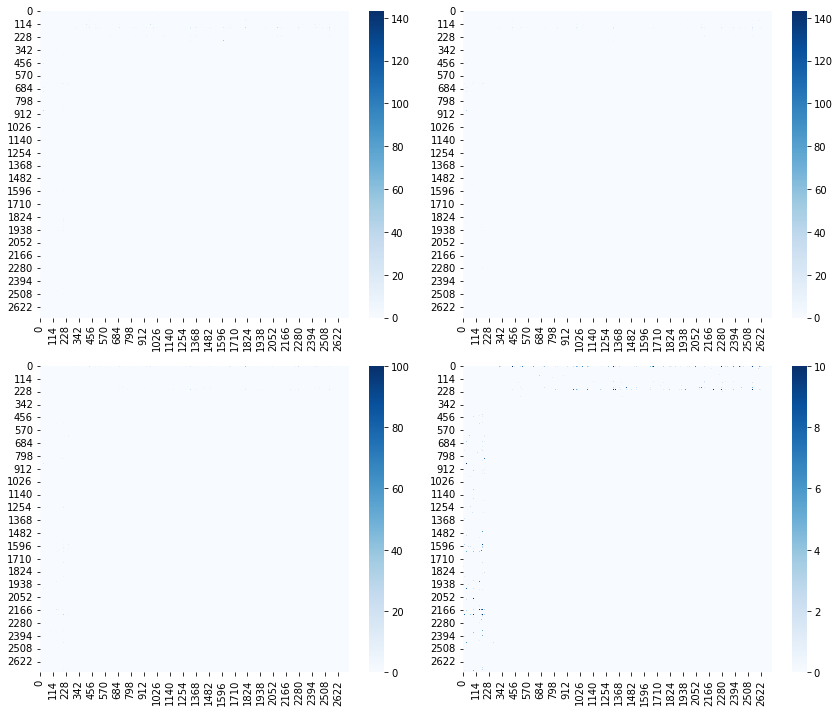

In [25]:
mobility_serie = mobility_df.groupby(['SendId', 'RecId']).sum()
row = np.array(mobility_serie.index.get_level_values(1).tolist())
col = np.array(mobility_serie.index.get_level_values(0).tolist())
val = mobility_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

# cercasi 70 Gb di ram, no perditempo
ns.visualize_adj(adj_matrix_crs)

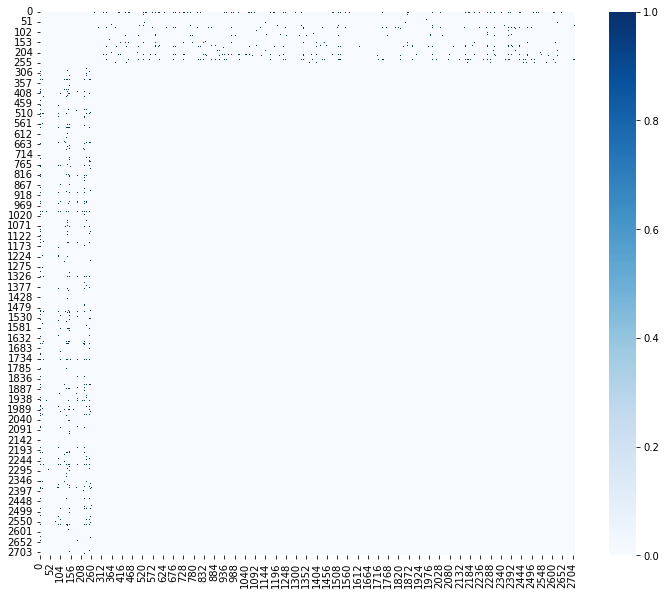

In [26]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
a_adj = adj_matrix_crs.toarray()
a_adj[a_adj>1] = 1
sns.heatmap(a_adj, cmap="Blues", ax=ax)
plt.show()

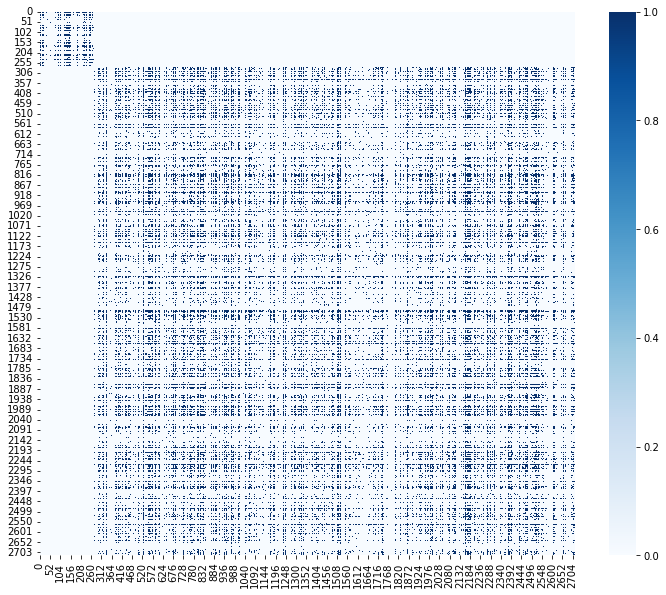

In [27]:
projection = adj_matrix_crs**2
fig, ax = plt.subplots(1,1,figsize=(12,10))
a_adj = projection.toarray()
a_adj[a_adj>1] = 1
sns.heatmap(a_adj, cmap="Blues", ax=ax)
plt.show()

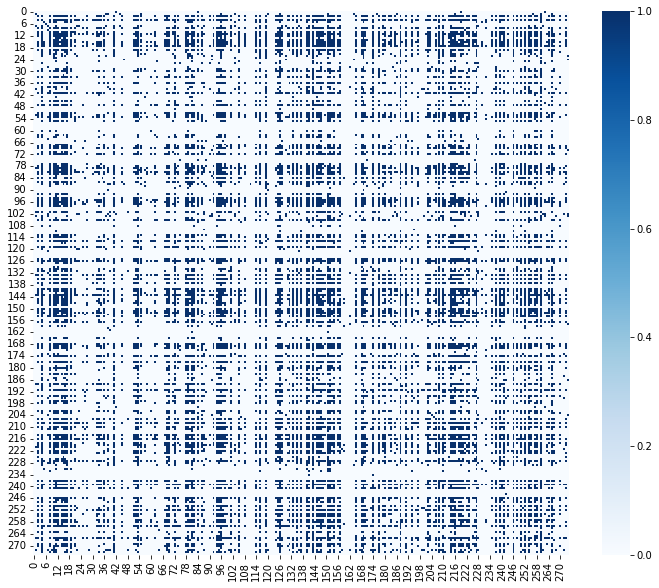

In [28]:
italian_matrix = projection[0:number_of_italian_node, 0:number_of_italian_node]
fig, ax = plt.subplots(1,1,figsize=(12,10))
a_adj = italian_matrix.toarray()
a_adj[a_adj>1] = 1
sns.heatmap(a_adj, cmap="Blues", ax=ax)
plt.show()

In [49]:
italian_df = pd.DataFrame(italian_nodes, columns=['Sending Organization'])
italian_df['SendId'] = (np.array(list(map(lambda x: node_position[x], italian_df['Sending Organization']))))
italian_df2 = pd.DataFrame(italian_nodes, columns=['Receiving Organization'])
italian_df2['RecId'] = (np.array(list(map(lambda x: node_position[x], italian_df2['Receiving Organization']))))
italian_df = italian_df.merge(italian_df2, how='cross')
italian_df['Participants'] = np.nan

rows, columns = italian_matrix.nonzero()
for r,c in zip(rows, columns):
    italian_df.at[(italian_df['SendId'] == c) &(italian_df['RecId'] == r), 'Participants']= italian_matrix[r,c]

italian_df = italian_df.dropna()
italian_df

,Sending Organization,SendId,Receiving Organization,RecId,Participants
276,"CONSERVATORIO DI MUSICA ""LUIGI CHERUBINI""",1,"CONSERVATORIO DI MUSICA ""LUIGI CHERUBINI""",1,2.0
282,"CONSERVATORIO DI MUSICA ""LUIGI CHERUBINI""",1,CONSERVATORIO DI MUSICA G.B.MARTINI,7,1.0
314,"CONSERVATORIO DI MUSICA ""LUIGI CHERUBINI""",1,"CONSERVATORIO DI MUSICA ""NICCOLÒ PICCINNI"" - BARI",39,2.0
327,"CONSERVATORIO DI MUSICA ""LUIGI CHERUBINI""",1,UNIVERSITA DEGLI STUDI DI ROMA FORO ITALICO,52,1.0
354,"CONSERVATORIO DI MUSICA ""LUIGI CHERUBINI""",1,UNIVERSITA DEGLI STUDI DI TRENTO,79,5.0
...,...,...,...,...,...
75452,"ACCADEMIA NAZIONALE D'ARTE DRAMMATICA ""SILVIO ...",274,CONSERVATORIO DI MUSICA &QUOT;G.VERDI&QUOT; DI...,102,2.0
75453,"ACCADEMIA NAZIONALE D'ARTE DRAMMATICA ""SILVIO ...",274,"CONSERVATORIO DI MUSICA ""G.VERDI"" DI MILANO",103,1.0
75508,"ACCADEMIA NAZIONALE D'ARTE DRAMMATICA ""SILVIO ...",274,"CONSERVATORIO STATALE DI MUSICA ""G.ROSSINI""",158,1.0
75536,"ACCADEMIA NAZIONALE D'ARTE DRAMMATICA ""SILVIO ...",274,"CONSERVATORIO STATALE DI MUSICA ""E. F. DALL'AB...",186,2.0


In [51]:
mobility_df = italian_df
adj_matrix_crs = italian_matrix
nodes_df = pd.DataFrame({'Nodes': italian_nodes})

mobility_df.rename({'Sending Organization': 'source','Receiving Organization': 'target', 'Participants':'weight'},axis=1, inplace=True)

nodes_component = ns.find_components(adj_matrix_crs, nodes_df)
components_n = nodes_component.groupby(by=["component"]).count()
display(components_n)
for i in range(1, 12):
    print("component ", i )
    nodes_component_i = nodes_component[nodes_component['component'] == i]
    display(nodes_component_i)

,Nodes
component,
0,253
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1


component  1


,Nodes,component
6,FONDAZIONE ISTITUTO TECNICO SUPERIORE PER LE N...,1


component  2


,Nodes,component
18,INSTITUTO POLITÉCNICO DE CASTELO BRANCO,2


component  3


,Nodes,component
50,UNIVERSITY OF ESSEX,3


component  4


,Nodes,component
56,UNIVERSITY OF LIMERICK,4


component  5


,Nodes,component
59,UNIVERSITE FRANCOIS RABELAIS DE TOURS,5


component  6


,Nodes,component
66,UNIVERSITE CATHOLIQUE DE LOUVAIN,6


component  7


,Nodes,component
76,CONSERVATORIO STATALE DI MUSICA C. POLLINI - P...,7


component  8


,Nodes,component
85,UNIVERSITE LYON 1 CLAUDE BERNARD,8


component  9


,Nodes,component
107,CAMPIANI1,9


component  10


,Nodes,component
109,"ACCADEMIA DI BELLE ARTI ""MARIO SIRONI""",10


component  11


,Nodes,component
112,ACCADEMIA DI BELLE ARTI ALDO GALLI - I.L.E.M. SRL,11


In [52]:
adj_matrix_crs, mobility_df, nodes_df = ns.keep_giant(ns.find_components(adj_matrix_crs, nodes_df), mobility_df)

### Degree distribution

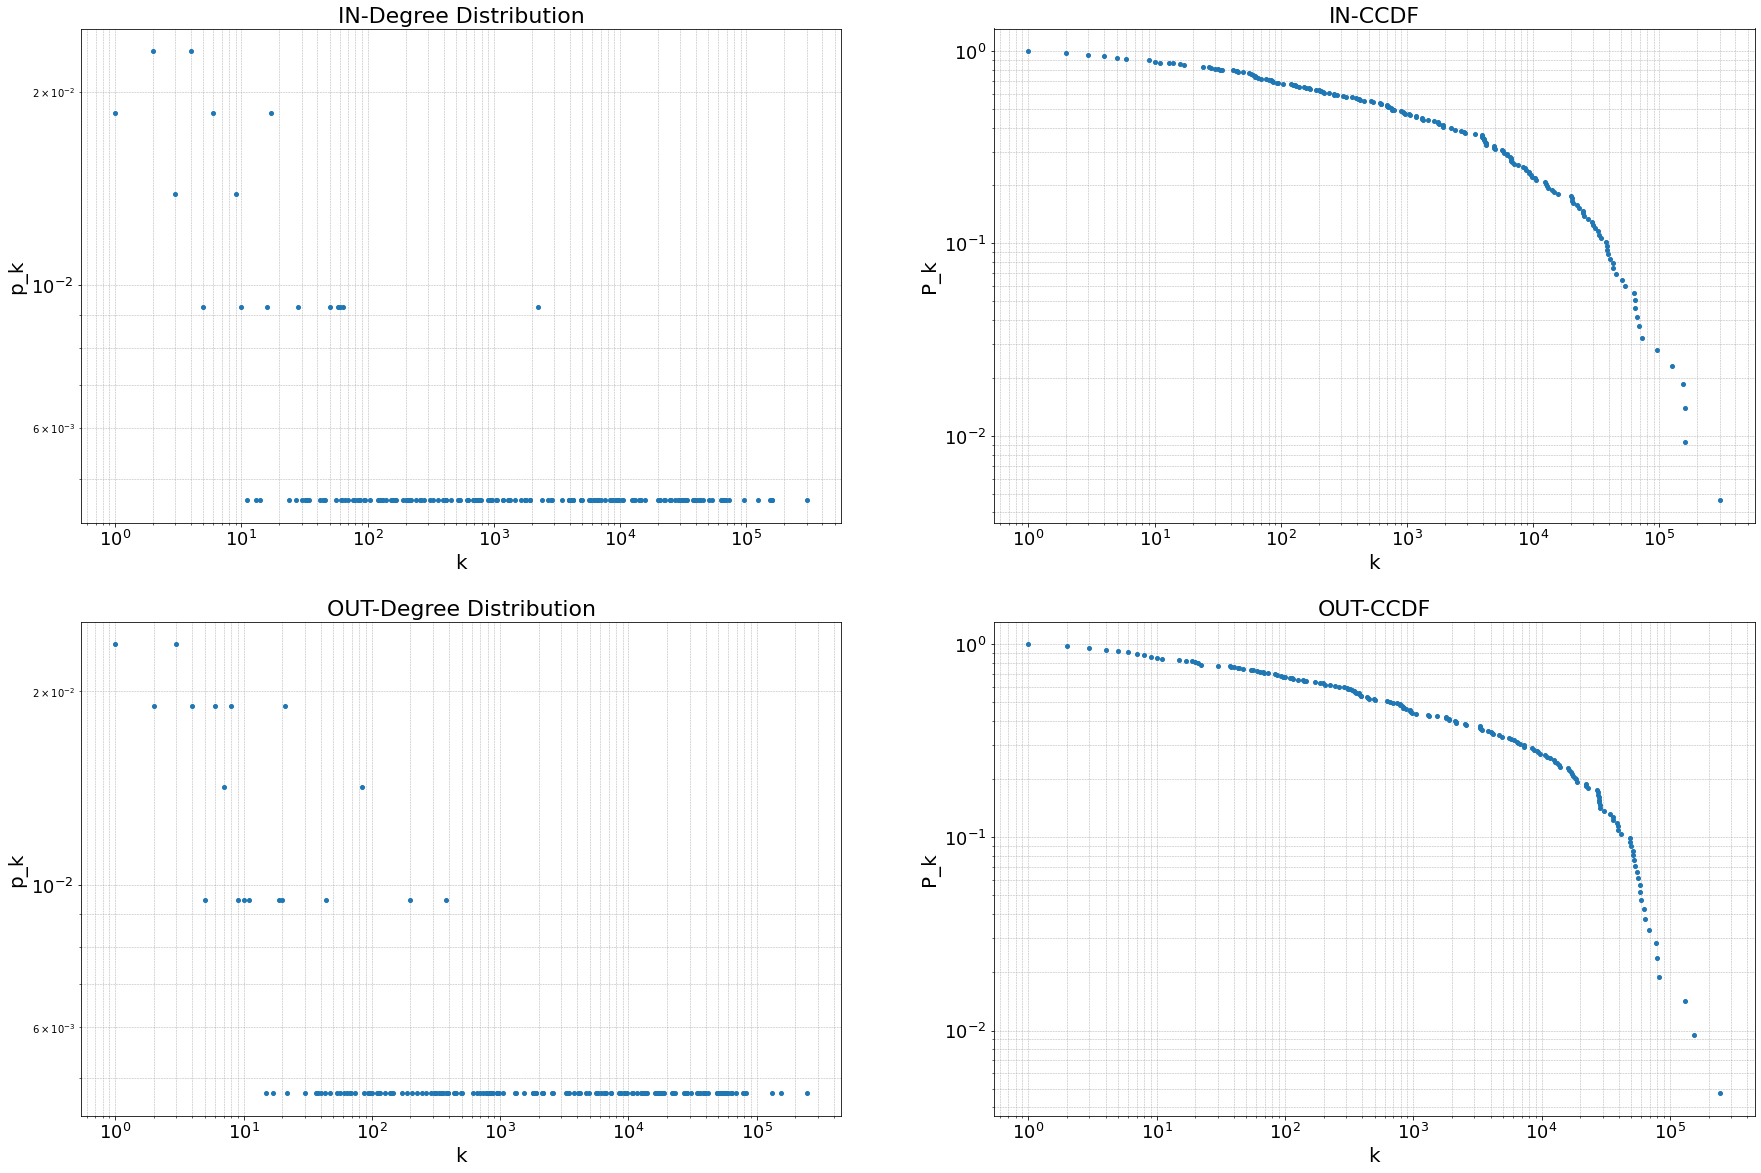

Top 10 for in degree


,Nodes,in degree
128,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,301706
196,POLITECNICO DI MILANO,160089
4,UNIVERSITA DEGLI STUDI DI PADOVA,159396
112,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,153476
218,UNIVERSITA DEGLI STUDI DI FIRENZE,124632
238,UNIVERSITA DEGLI STUDI DI TORINO,95062
31,UNIVERSITA COMMERCIALE LUIGI BOCCONI,73057
188,UNIVERSITA DEGLI STUDI DI MILANO,69468
141,POLITECNICO DI TORINO,66288
194,UNIVERSITA DEGLI STUDI ROMA TRE,64534


Top 10 for out degree


,Nodes,out degree
128,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,245660
238,UNIVERSITA DEGLI STUDI DI TORINO,153099
112,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,131231
4,UNIVERSITA DEGLI STUDI DI PADOVA,82361
188,UNIVERSITA DEGLI STUDI DI MILANO,79256
207,UNIVERSITA' DEGLI STUDI DI MILANO-BICOCCA,78029
196,POLITECNICO DI MILANO,68569
152,UNIVERSITA DEGLI STUDI DI SASSARI,64256
169,UNIVERSITA DEGLI STUDI DI NAPOLI FEDERICO II,63093
10,UNIVERSITA DEGLI STUDI DI TRIESTE,59143


In [53]:
scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
ns.display_top_n(scores, 10, 'in degree')
ns.display_top_n(scores, 10, 'out degree')

### Estimating $\gamma$ 

In [54]:
from collections import Counter
from statistics import mean

d_in = scores['in degree']
d_in = d_in[d_in>0]
d_out = scores['out degree']
d_out = d_out[d_out>0]
kmin = 1500
d2_in = d_in[d_in>kmin]
d2_out = d_out[d_out>kmin]

sorted_d = sorted(d_in)
occurrence = Counter(sorted_d)
x_in = list(occurrence.keys())
y_in = list(occurrence.values())
y_in = y_in/np.sum(y_in)

sorted_d = sorted(d_out)
occurrence = Counter(sorted_d)
x_out = list(occurrence.keys())
y_out = list(occurrence.values())
y_out = y_out/np.sum(y_out)

Pk_in = 1 - np.cumsum(y_in)
Pk_in[-1] = 1 
Pk_in = sorted(Pk_in, reverse = True)
Pk_out = 1 - np.cumsum(y_out)
Pk_out[-1] = 1 
Pk_out = sorted(Pk_out, reverse = True)

In [55]:
ga_in = 1 + 1/mean(np.array(np.log(d2_in/kmin)))
ga_out = 1 + 1/mean(np.array(np.log(d2_out/kmin)))
C_in = (ga_in-1)*kmin**(ga_in-1) # normalization condition
C_out = (ga_out-1)*kmin**(ga_out-1)

pos_in = np.argmax(np.array(x_in)>=kmin)
pos_out = np.argmax(np.array(x_out)>=kmin)

P_kmin_in = Pk_in[pos_in] # constant value that shifts the line where the data are placed
pk_in = C_in*P_kmin_in*x_in**-ga_in
Pk_est_in = C_in*P_kmin_in*x_in**(-(ga_in-1))/(ga_in-1) 

P_kmin_out = Pk_out[pos_out] # constant value that shifts the line where the data are placed
pk_out = C_out*P_kmin_out*x_out**-ga_out
Pk_est_out = C_out*P_kmin_out*x_out**(-(ga_out-1))/(ga_out-1) 

1.4701897037112337 1.429720479862956


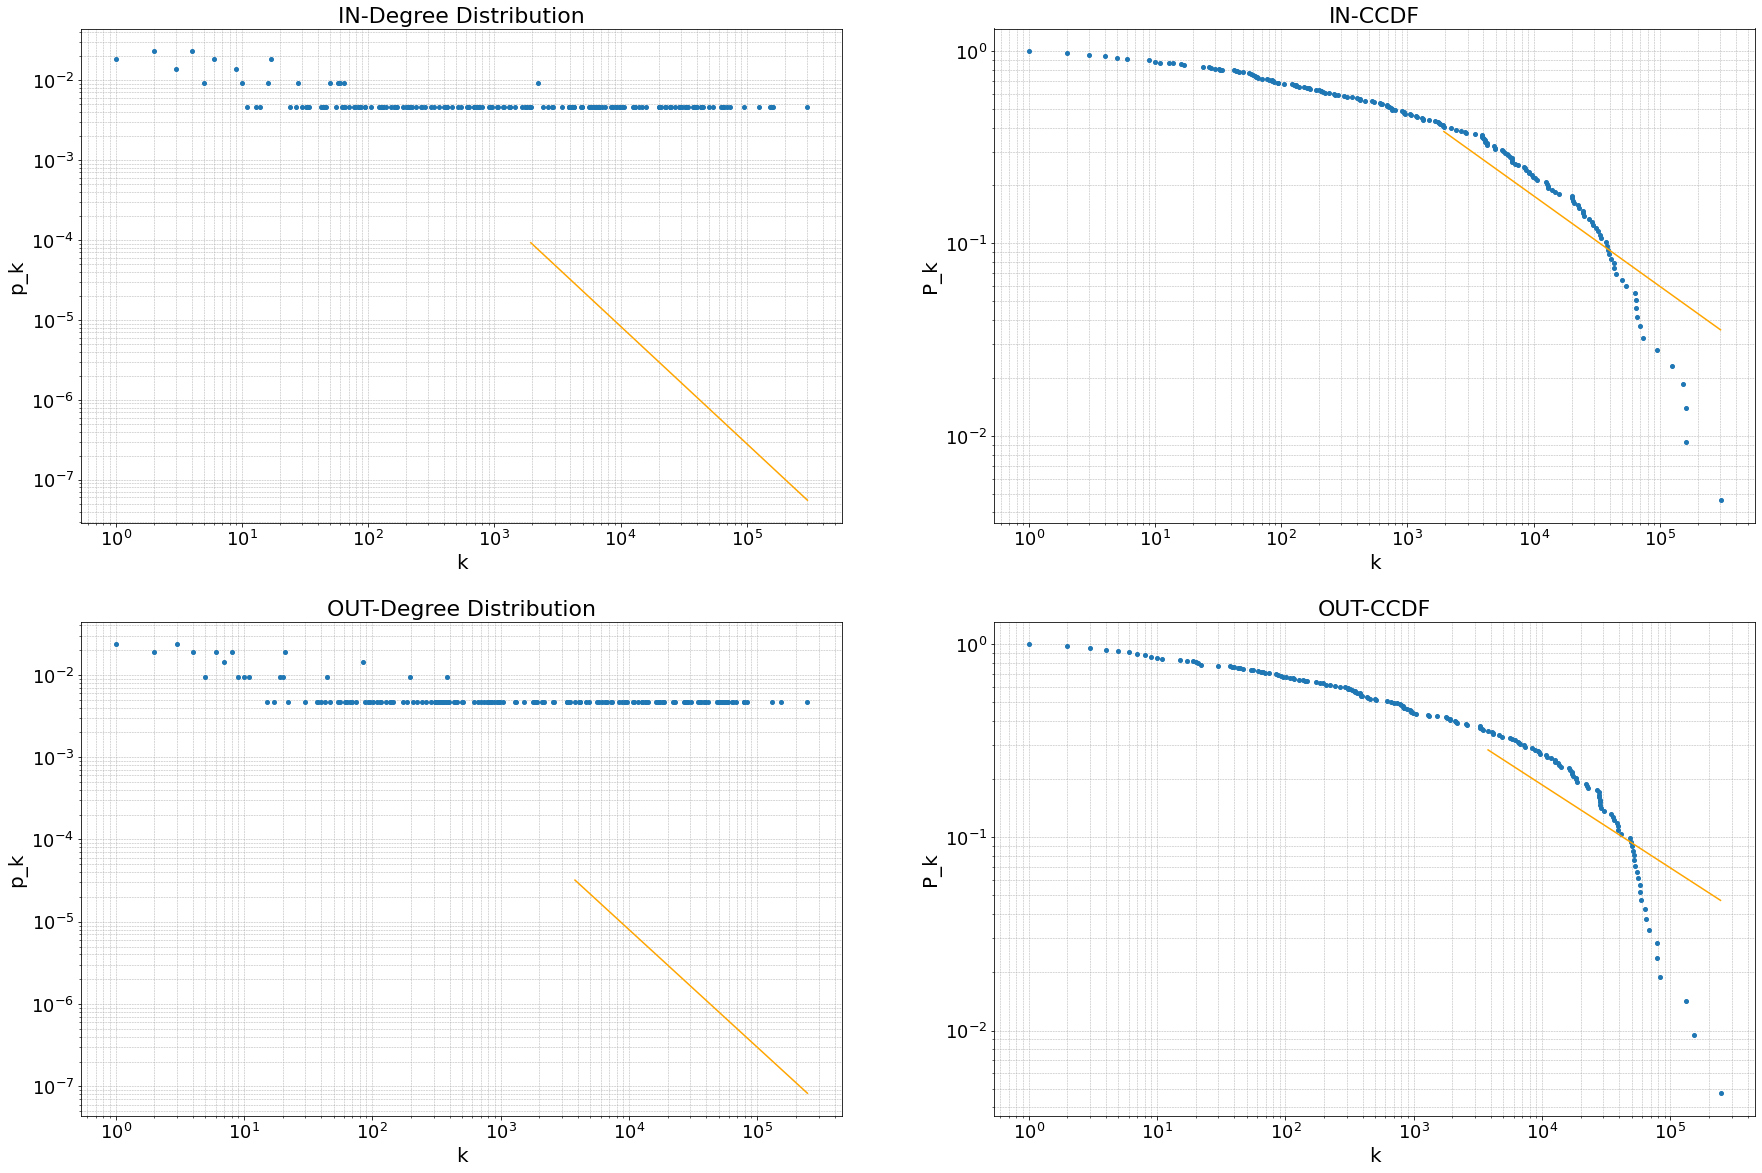

In [56]:
fig, ax = plt.subplots(2, 2, figsize = (30, 20))

def plot_gamma(ax, x, y, title, p, cumulative=False):
    ax.loglog(x, y, 'o', markersize = 4)
    idx = 100 
    ax.loglog(x[100:], p[100:], color='orange')
    ax.grid(which='both', linestyle='--', linewidth=0.5)
    ax.set_title(title, size = 22)
    ax.set_xlabel("k", size = 20)
    if cumulative:
        ax.set_ylabel("P_k", size = 20)
    else:
        ax.set_ylabel("p_k", size = 20)
    ax.tick_params(labelsize=18)
    ax.tick_params(labelsize=18)

plot_gamma(ax[0,0], x_in, y_in, "IN-Degree Distribution", pk_in)
plot_gamma(ax[0,1], x_in, Pk_in, "IN-CCDF", Pk_est_in, True)
plot_gamma(ax[1,0], x_out, y_out, "OUT-Degree Distribution", pk_out)
plot_gamma(ax[1,1], x_out, Pk_out, "OUT-CCDF", Pk_est_out, True)
print(ga_in, ga_out)
plt.show()

### Estimating $\gamma$ through a linear fit with log binning

In [57]:
# Log binning 
nbins = 20
bins = np.logspace(0, 3.3, nbins)

hist_in = np.histogram(d_in, bins=bins, density=True)
hist_out = np.histogram(d_out, bins=bins, density=True)
logbin_p_k_in = hist_in[0]
logbin_p_k_out = hist_out[0]
middle_bins = np.sqrt( np.delete(bins, 0) * np.delete(bins, nbins-1) )
kmin = 100
mask = np.log10(middle_bins) > np.log10(kmin)
x = np.log10( middle_bins[mask] )
y_in = np.log10( logbin_p_k_in[mask] )
y_out = np.log10( logbin_p_k_out[mask] )

# Linear fit
params_in = np.polyfit(x, y_in, deg =1)
params_out = np.polyfit(x, y_out, deg =1)
lin_gamma_in = -params_in[0]
lin_gamma_out = -params_out[0]

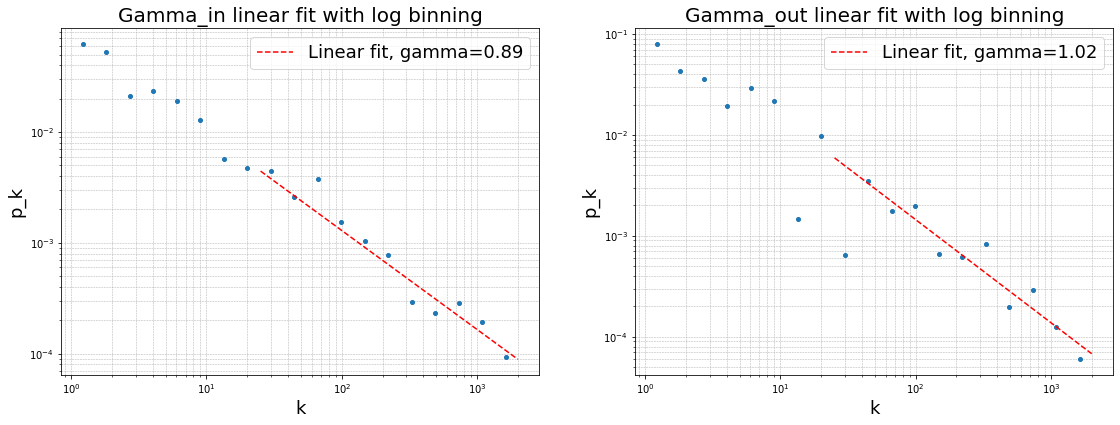

In [58]:
plt.figure(figsize=(60, 60))
plt.subplot(8, 6, 1)
plt.loglog(middle_bins, logbin_p_k_in , 'o', markersize = 4)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("Gamma_in linear fit with log binning", size = 20)
plt.xlabel("k", size = 18)
plt.ylabel("p_k", size = 18)
x2 = np.logspace(1.4,3.3,100)
y2 = np.full( 100, 10**(params_in[1])*x2**(-lin_gamma_in) ) 
plt.plot(x2,y2, label ="Linear fit, gamma="+str( np.round(lin_gamma_in,2) ), color="red", linestyle="--")
plt.legend(fontsize=18)

plt.subplot(8, 6, 2)
plt.loglog(middle_bins, logbin_p_k_out , 'o', markersize = 4)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("Gamma_out linear fit with log binning", size = 20)
plt.xlabel("k", size = 18)
plt.ylabel("p_k", size = 18)
x2 = np.logspace(1.4,3.3,100)
y2 = np.full( 100, 10**(params_out[1])*x2**(-lin_gamma_out) ) 
plt.plot(x2,y2, label ="Linear fit, gamma="+str( np.round(lin_gamma_out,2) ), color="red", linestyle="--")
plt.legend(fontsize=18)

plt.show()

### HITS (NetworkX)

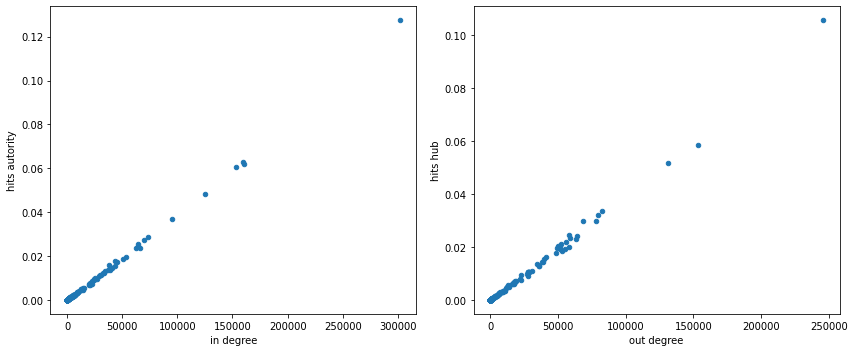

Top 10 for hits hub


,Nodes,hits hub
128,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.105405
238,UNIVERSITA DEGLI STUDI DI TORINO,0.058449
112,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.051489
4,UNIVERSITA DEGLI STUDI DI PADOVA,0.033370
188,UNIVERSITA DEGLI STUDI DI MILANO,0.031825
207,UNIVERSITA' DEGLI STUDI DI MILANO-BICOCCA,0.029831
196,POLITECNICO DI MILANO,0.029679
141,POLITECNICO DI TORINO,0.024470
152,UNIVERSITA DEGLI STUDI DI SASSARI,0.024036
10,UNIVERSITA DEGLI STUDI DI TRIESTE,0.023270


Top 10 for hits autority


,Nodes,hits autority
128,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.127436
4,UNIVERSITA DEGLI STUDI DI PADOVA,0.062870
196,POLITECNICO DI MILANO,0.062068
112,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.060527
218,UNIVERSITA DEGLI STUDI DI FIRENZE,0.048215
238,UNIVERSITA DEGLI STUDI DI TORINO,0.036840
31,UNIVERSITA COMMERCIALE LUIGI BOCCONI,0.028748
188,UNIVERSITA DEGLI STUDI DI MILANO,0.027372
194,UNIVERSITA DEGLI STUDI ROMA TRE,0.025541
244,UNIVERSITA DI PISA,0.024542


In [59]:
df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'hits hub')
ns.display_top_n(scores, 10, 'hits autority')

### PageRank (NetworkX)

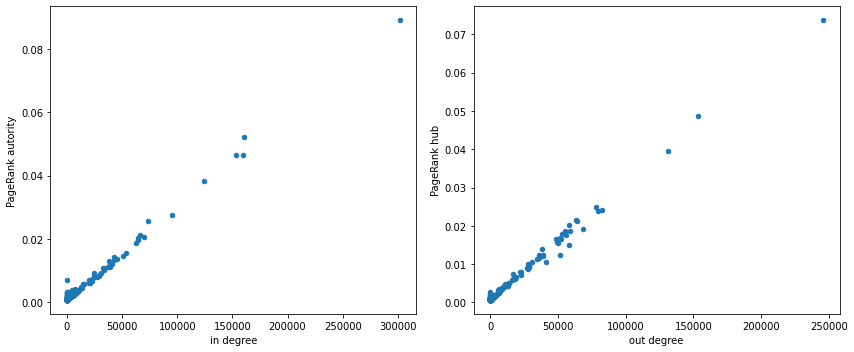

Top 10 for PageRank hub


,Nodes,PageRank hub
128,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.073620
238,UNIVERSITA DEGLI STUDI DI TORINO,0.048671
112,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.039597
207,UNIVERSITA' DEGLI STUDI DI MILANO-BICOCCA,0.024867
4,UNIVERSITA DEGLI STUDI DI PADOVA,0.024257
188,UNIVERSITA DEGLI STUDI DI MILANO,0.023997
169,UNIVERSITA DEGLI STUDI DI NAPOLI FEDERICO II,0.021579
152,UNIVERSITA DEGLI STUDI DI SASSARI,0.021314
107,UNIVERSITA DEGLI STUDI DI PALERMO,0.020312
196,POLITECNICO DI MILANO,0.019061


Top 10 for PageRank autority


,Nodes,PageRank autority
128,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.089071
196,POLITECNICO DI MILANO,0.052143
112,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.046395
4,UNIVERSITA DEGLI STUDI DI PADOVA,0.046374
218,UNIVERSITA DEGLI STUDI DI FIRENZE,0.038281
238,UNIVERSITA DEGLI STUDI DI TORINO,0.027461
31,UNIVERSITA COMMERCIALE LUIGI BOCCONI,0.025661
141,POLITECNICO DI TORINO,0.021383
188,UNIVERSITA DEGLI STUDI DI MILANO,0.020497
244,UNIVERSITA DI PISA,0.020148


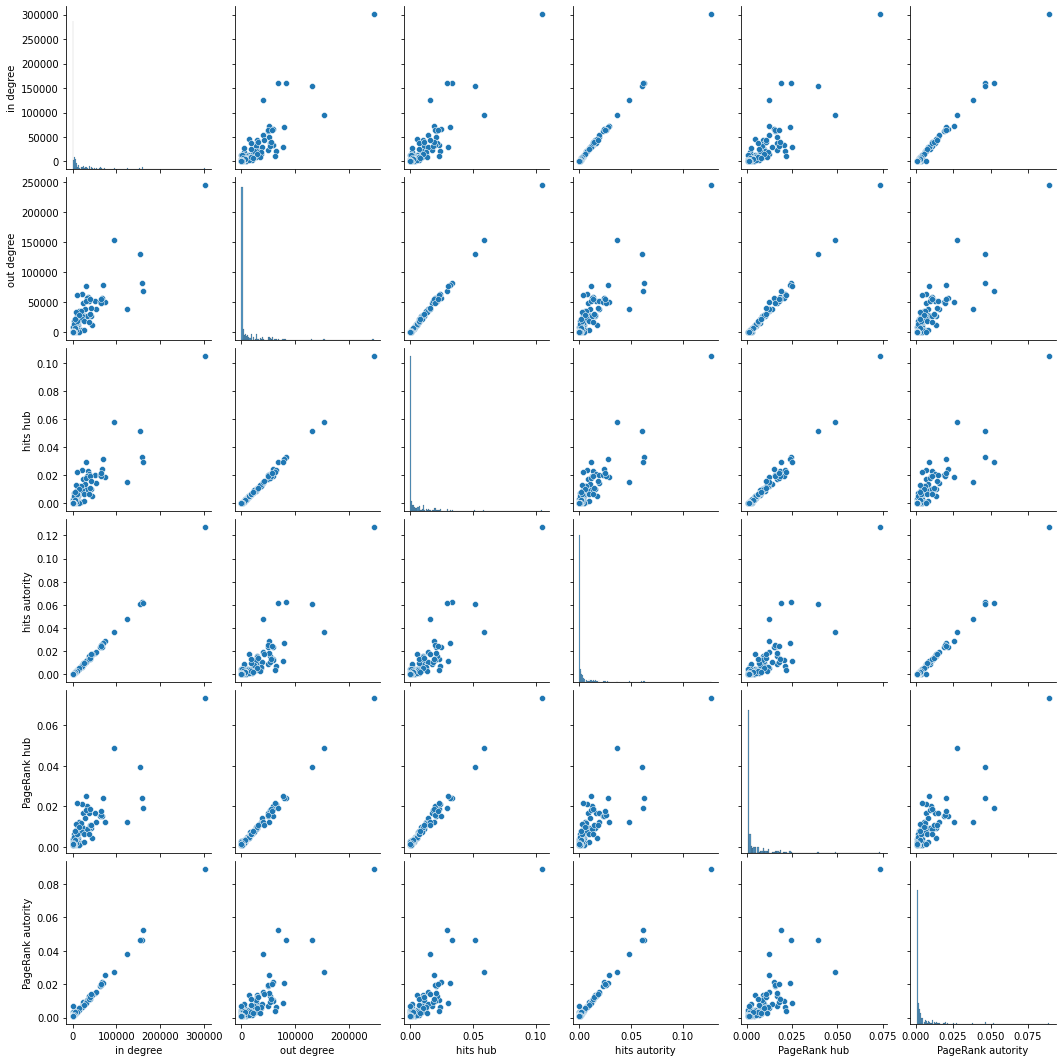

In [60]:
df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'PageRank hub')
ns.display_top_n(scores, 10, 'PageRank autority')
# ci vuole troppo a farlo
sns.pairplot(scores[['in degree', 'out degree',  'hits hub',
       'hits autority', 'PageRank hub', 'PageRank autority']])
plt.show()
# from IPython.display import Image
# Image('pairplot_score.png',)

### Assortativity

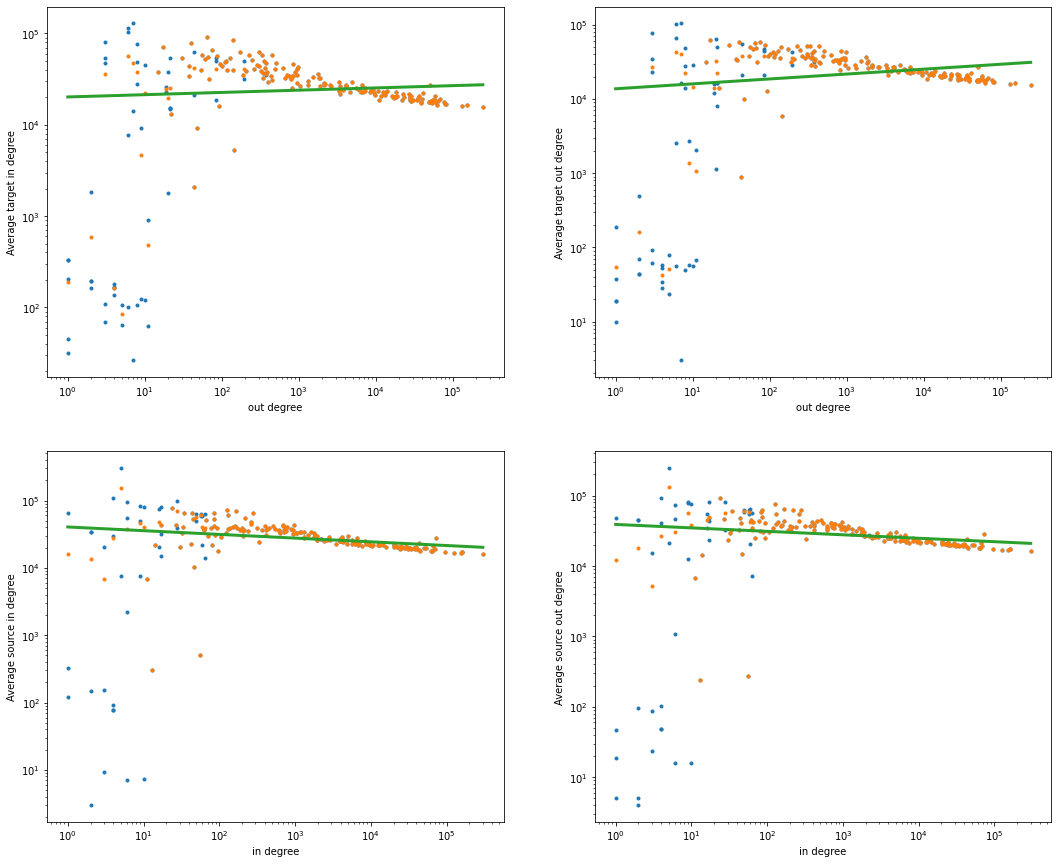

(0.024754664537987595,
 0.06605393866346729,
 -0.0550812750752602,
 -0.04910790590356632)

In [61]:
edges = mobility_df.copy()
ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True)

### Robustness

In [62]:
#attack: removing hubs first
nodes_byhub = scores.sort_values('PageRank hub', ascending=False)['NodeID']
indices = list(nodes_byhub)
uni_df = mobility_df.copy()
GC_frac_a = [1]
for node in indices:
    uni_df = uni_df.loc[(uni_df['sourceID'] != node) & (uni_df['targetID'] != node)]
    temp_serie = uni_df.groupby(['sourceID', 'targetID']).sum()
    row = np.array(temp_serie.index.get_level_values(1).tolist())
    col = np.array(temp_serie.index.get_level_values(0).tolist())
    val = temp_serie.values
    temp_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
    GC_frac_a.append(ns.fraction_in_giant(temp_adj))


In [63]:
#random node removal
import random
#10 by 10, with average over 10 trials each time
intervals = list(range(10, len(nodes_byhub+1), 10))
uni_df = mobility_df.copy()
GC_frac_r = [1]
for i in intervals:
    i_GC_frac = []
    for j in range(10):
        removed = random.sample(indices, i)
        temp_df = uni_df.loc[~(uni_df['sourceID'].isin(removed) | (uni_df['targetID'].isin(removed)))]
        temp_serie = temp_df.groupby(['sourceID', 'targetID']).sum()
        row = np.array(temp_serie.index.get_level_values(1).tolist())
        col = np.array(temp_serie.index.get_level_values(0).tolist())
        val = temp_serie.values
        temp_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
        i_GC_frac.append(ns.fraction_in_giant(temp_adj))
    GC_frac_r.append(sum(i_GC_frac)/10)

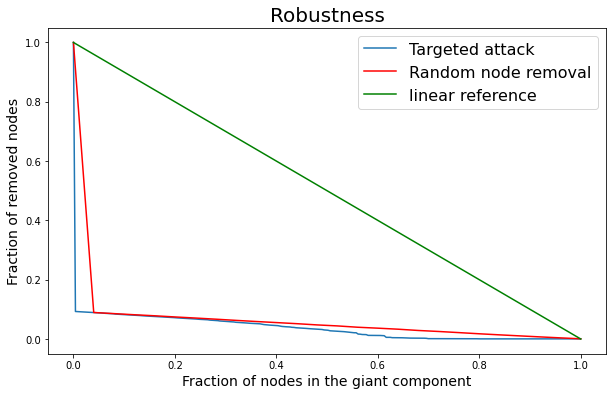

In [64]:
fig = plt.figure(figsize=(10,6))
plt.plot([i/len(nodes_byhub) for i in range(len(nodes_byhub)+1)], GC_frac_a, label='Targeted attack')
plt.plot([0]+[i/(len(intervals)*10) for i in intervals], GC_frac_r, 'r', label='Random node removal')
plt.plot([0,1], [1,0], 'g', label='linear reference')
plt.xlabel('Fraction of nodes in the giant component', size=14)
plt.ylabel('Fraction of removed nodes', size=14)
plt.title('Robustness', size=20)
plt.legend(fontsize=16)
plt.show()